In [115]:
from commonfunctions import *
from skimage.exposure import histogram
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.morphology import binary_opening, binary_erosion, binary_closing, thin
from skimage.filters import gaussian as gaussian_filter
import cv2 as cv
import os
from skimage import img_as_ubyte
import functools 

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
width = 60
height = 60

class character:
    def __init__(self, char, template):
        self.char = char
        self.template = cv.resize(cv.imread(template,cv.IMREAD_GRAYSCALE), (60, 60), interpolation = cv.INTER_AREA)
        self.col_sum = np.zeros(shape=(height,width))
        self.corr = 0
        
database_characters = []

# Letters
Alf = character("أ", 'charImages/alf3.jpg')
Alf2 = character("أ", 'charImages/alf5.png')
Alf3 = character("أ", 'charImages/alf6.jpg')
Sen = character("س", 'charImages/sen.jpg')
Non = character("ن", 'charImages/non2.png')
Non2 = character("ن", 'charImages/non5.png')
Non3 = character("ن", 'charImages/non3.jpg')
Yaa = character("ى", 'charImages/yeh.jpg')
Yaa2 = character("ى", "charImages/ya'.jpg")
Lam = character("ل", 'charImages/lam3.jpg')
Baa = character("ب", 'charImages/30.jpg')
Baa2 = character("ب", "charImages/ba'.jpg")
Baa3 = character("ب", "charImages/ba'2.jpg")
Dal = character("د", 'charImages/32.jpg')
Dal2 = character("د", 'charImages/dal4.jpg')
Reh = character("ر", 'charImages/36.jpg')
Reh2 = character("ر", 'charImages/reh5.png')
Reh3 = character("ر", "charImages/ra'.jpg")
Zay = character("ز", "charImages/zay.jpg")
Qaf = character("ق", 'charImages/86.jpg')
Qaf2 = character("ق", 'charImages/88.jpg')
Qaf3 = character("ق", 'charImages/qaf.jpg')
Qaf4 = character("ق", 'charImages/qaf2.jpg')
Mim = character("م", 'charImages/33.jpg')
Waw = character("و", 'charImages/7.jpg')
Waw2 = character("و", 'charImages/waw2.jpg')
Tah = character("ط", 'charImages/82.jpg')
Sad = character("ص", 'charImages/42.jpg')
Gem = character("ج", 'charImages/102.jpg')
Ein = character("ع", 'charImages/ein.png')
Heh = character("ه", 'charImages/heh2.jpg')
Heh2 = character("ه", 'charImages/heh3.png')
Heh3 = character("ه", 'charImages/heh4.png')
Fih = character("ف", 'charImages/fih3.png')
Fih2 = character("ف", 'charImages/fih2.jpg')
Fih3 = character("ف", "charImages/fa'.jpg")


# Numbers
One = character("1", 'charImages/3.jpg')
Two = character("2", 'charImages/4.jpg')
Two2 = character("2", 'charImages/222.jpg')
Three = character("3", 'charImages/8.jpg')
Four = character("4", 'charImages/11.jpg')
Five = character("5", 'charImages/15.jpg')
Six = character("6", 'charImages/18.jpg')
Seven = character("7", 'charImages/21.jpg')
Eight = character("8", 'charImages/25.jpg')
Nine = character("9", 'charImages/27.jpg')


# Add to database
database_characters.append(Alf)
database_characters.append(Alf2)
database_characters.append(Alf3)
database_characters.append(Baa)
database_characters.append(Baa2)
database_characters.append(Baa3)
database_characters.append(Dal)
database_characters.append(Dal2)
database_characters.append(Reh)
database_characters.append(Reh2)
database_characters.append(Reh3)
database_characters.append(Zay)
database_characters.append(Sen)
database_characters.append(Qaf)
database_characters.append(Qaf2)
database_characters.append(Qaf3)
database_characters.append(Qaf4)
database_characters.append(Mim)
database_characters.append(Tah)
database_characters.append(Sad)
database_characters.append(Waw)
database_characters.append(Waw2)
database_characters.append(Gem)
database_characters.append(Lam)
database_characters.append(Yaa)
database_characters.append(Yaa2)
database_characters.append(Non)
database_characters.append(Non2)
database_characters.append(Non3)
database_characters.append(Ein)
database_characters.append(Heh)
database_characters.append(Heh2)
database_characters.append(Heh3)
database_characters.append(Fih)
database_characters.append(Fih2)
database_characters.append(Fih3)
database_characters.append(Yeh)


database_characters.append(One)
database_characters.append(Two)
database_characters.append(Two2)
database_characters.append(Three)
database_characters.append(Four)
database_characters.append(Five)
database_characters.append(Six)
database_characters.append(Seven)
database_characters.append(Eight)
database_characters.append(Nine)

In [171]:
def getSimilarity(img1, img2):
    dim = (60,60)
    img1 = cv.GaussianBlur(img1,(19,19),0)
    img2 = cv.GaussianBlur(img2,(19,19),0)
    img1 = cv.resize(img1, dim, interpolation = cv.INTER_AREA)
    img2 = cv.resize(img2, dim, interpolation = cv.INTER_AREA)
    ret2,img1 = cv.threshold(img1,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret2,img2 = cv.threshold(img2,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    sim = img1 - img2
    sim = sim * sim
    sim = np.sum(sim)
    sim = np.sqrt(sim)
    return sim

In [195]:
dim = (60, 60)
class characterContour:
    def __init__(self, char, template):
        self.char = char
        self.template = cv.resize(template, dim, interpolation = cv.INTER_AREA)
        self.col_sum = np.zeros(shape=(height,width))
        self.corr = 0

def detectChar(Unk_char):
    Unk_char.corr, Unk_char.col_sum = char_calculations(Unk_char.template, height, width)
    r = 500000000000
    curr_r = 500000000000
    for j in database_characters:
        curr_r = similarity = getSimilarity(Unk_char.template,j.template)
        if curr_r < r:
            Unk_char.char = j.char
            r = curr_r
    return Unk_char.char

def movePointBy90(hieght, width, i, j):
    iNew = -j + width - 1
    jNew = i
    return int(iNew), int(jNew)

def rotateMatrix90(mat):
    image2 = np.zeros([mat.shape[1], mat.shape[0]])
    for i in range(mat.shape[0]-1):
        for j in range(mat.shape[1]-1):
            newPoint = movePointBy90(mat.shape[0], mat.shape[1], i, j)
            image2[newPoint[0], newPoint[1]]=mat[i,j]
    return image2
def rotateMatrixNTimes(mat, n=1):
    for i in range(0, n):
        mat = rotateMatrix90(mat)
    return mat


def checkRange(width , Xmin,Xmax):
    minWidth , maxWidth = width * .45 , width *.55
    return not( (minWidth < Xmin and Xmin < maxWidth) and (minWidth < Xmax and Xmax < maxWidth))
    

def getChars(img):
    imgRows, imgCols = img.shape
    charTexts = []
    contours = find_contours(img, 0.8)
    with_boxes  = np.zeros(img.shape, dtype=float)
    bounding_boxes = []
    for contour in contours:
        Xmin = int(np.min(contour[:,1]))
        Xmax = int(np.max(contour[:,1]))
        Ymin = int(np.min(contour[:,0]))
        Ymax = int(np.max(contour[:,0]))
        bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
    bounding_boxes.sort(key=lambda x: x[0])
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        absWidthDifference = abs(Ymax-Ymin)
        if(absWidthDifference == 0):
            absWidthDifference = 1
        
        if(abs(Xmax-Xmin)/absWidthDifference >= 0.12 and abs(Xmax-Xmin)/absWidthDifference <= 1.9 and abs(Ymax-Ymin) > 15 and checkRange(imgCols, Xmin, Xmax)):
            rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=with_boxes.shape)
            with_boxes[rr, cc] = 1 #set color black
            char = img[rr,cc]
            char = rotateMatrixNTimes(char, 3)
            char = np.fliplr(char)
            rows, cols = char.shape
            char = char[1:rows-1,1:cols-1] # Cancel black borders (thickness is only 1 pixel)
            char = characterContour("Unknown", img_as_ubyte(char))
            textChar = detectChar(char)
            charTexts.append(textChar)
            #show_images([char.template], ["Char"])
    charTexts.reverse()
    return charTexts


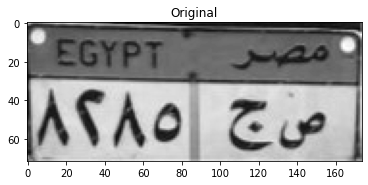

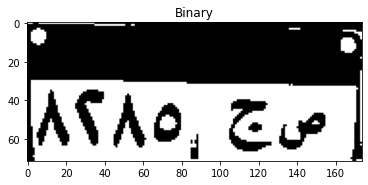

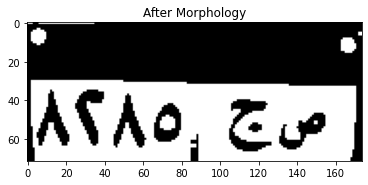

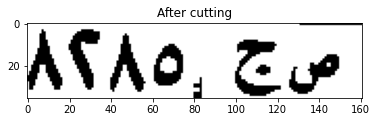

['ص', 'ج', '5', '8', '2', '8']


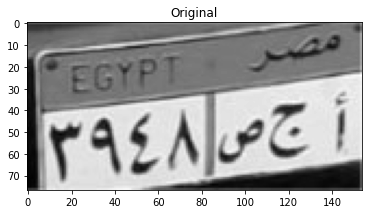

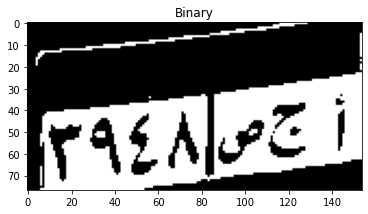

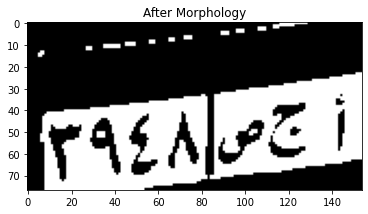

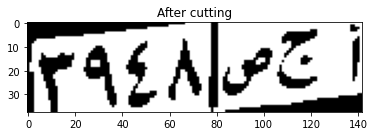

['أ', 'ص', '8', '4', '9', '3', 'ع']


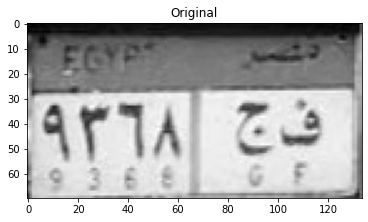

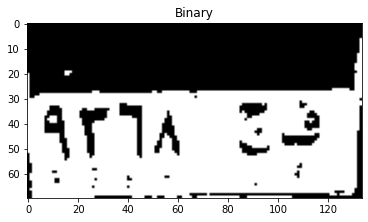

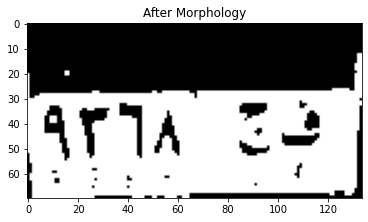

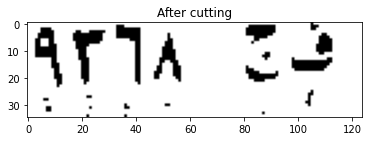

['8', '6', '3', '9']


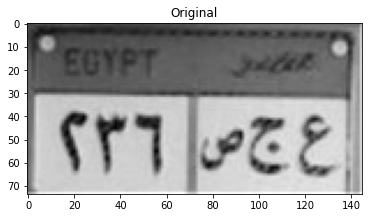

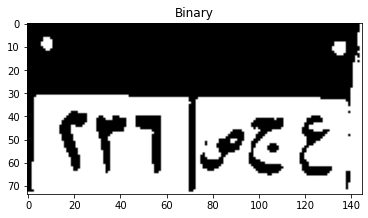

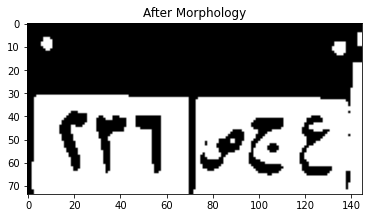

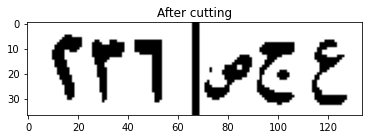

['ع', 'ج', 'ص', '6', '3', '2']


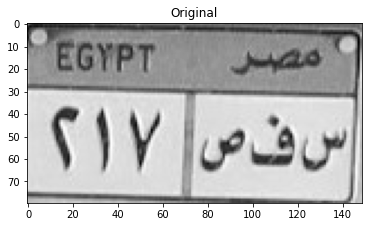

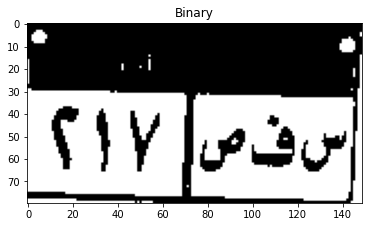

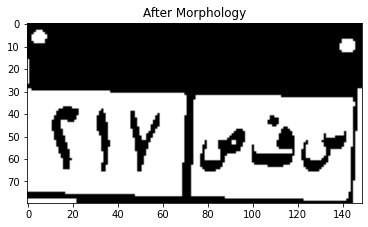

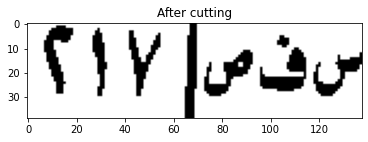

['س', 'ف', 'ص', '7', '1', '2']


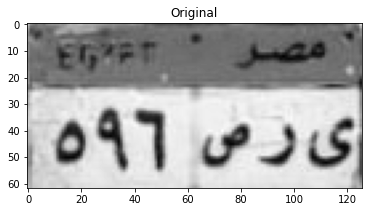

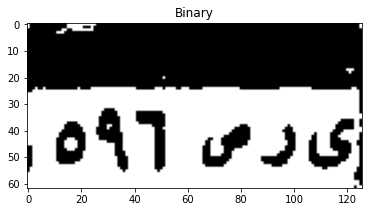

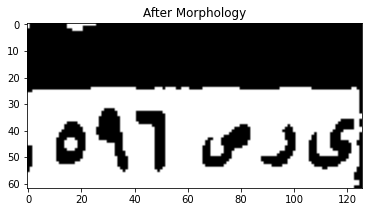

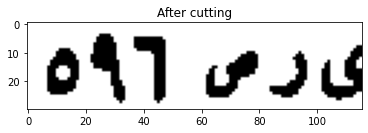

['ى', 'ر', 'ص', '6', '9', '5']


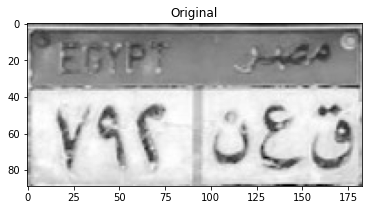

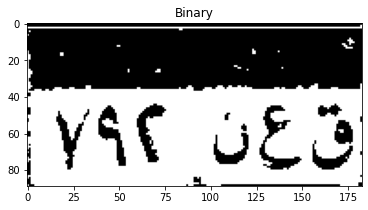

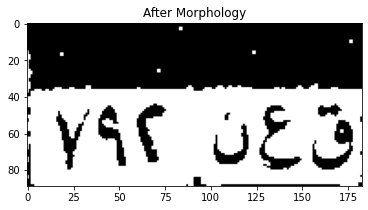

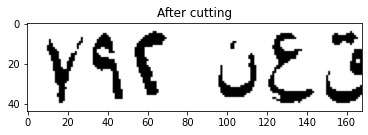

['ق', 'ع', 'ن', '2', '9', '7']


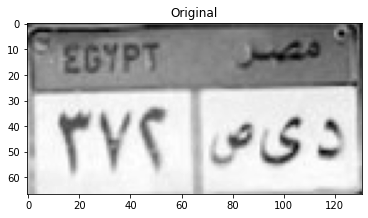

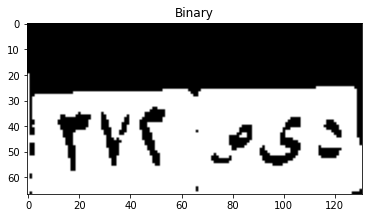

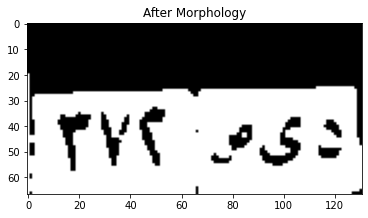

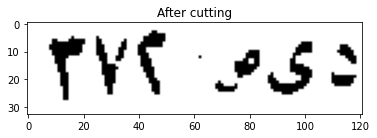

['ى', '2', '1', '3']


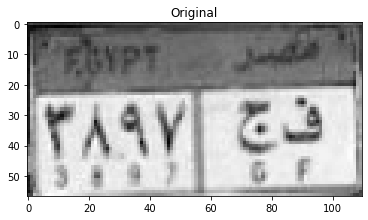

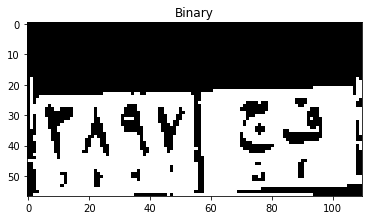

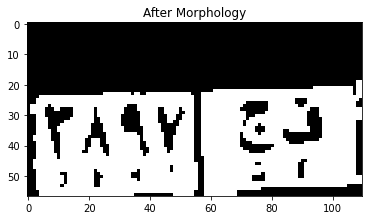

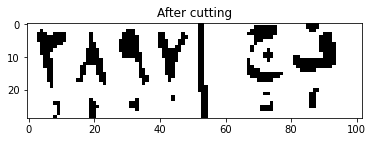

['9', 'ه', '3']


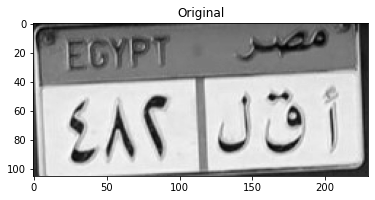

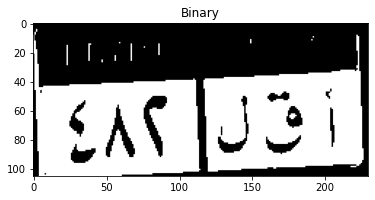

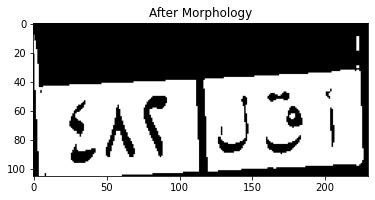

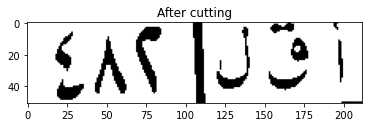

['ر', '2', '8', 'ب']


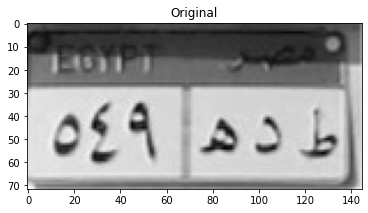

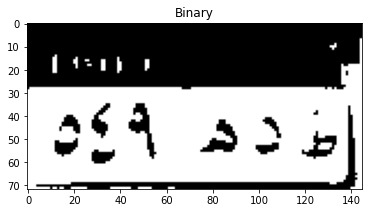

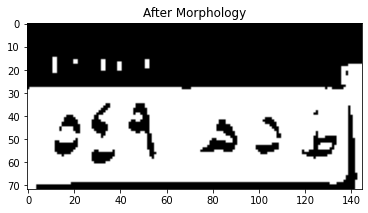

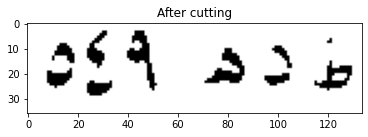

['9']


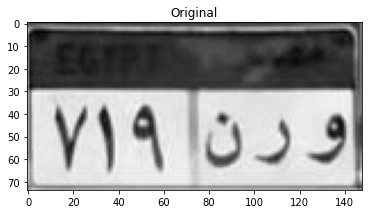

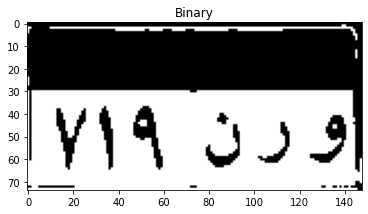

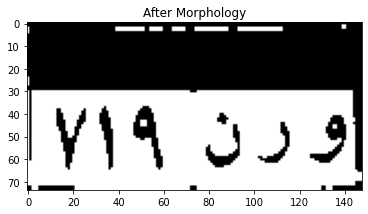

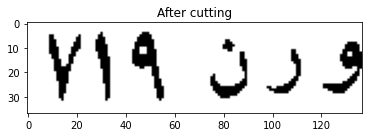

['و', 'ر', 'ن', '9', '1', '7']


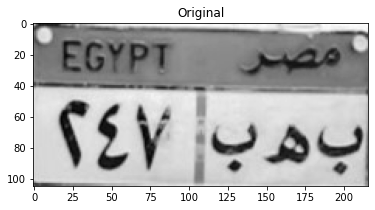

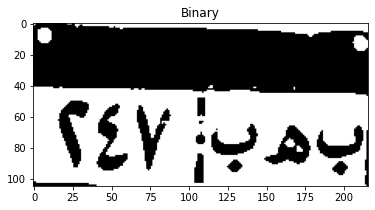

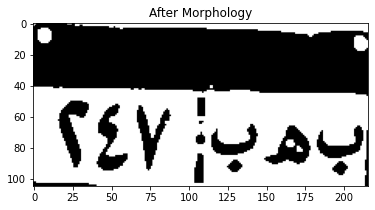

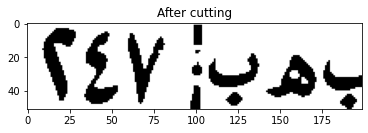

['ب', 'ه', 'ب', '7', '4', '2']


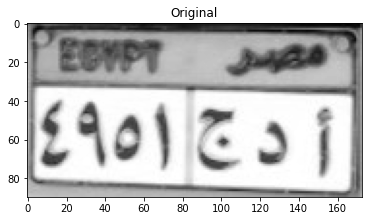

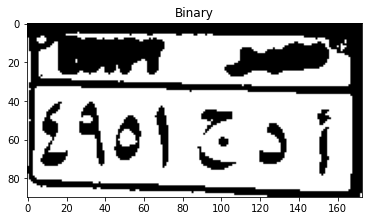

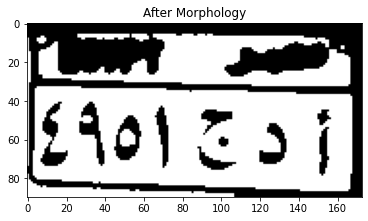

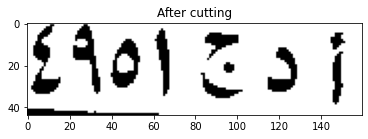

['أ', 'د', '6', '5', '9', '4']


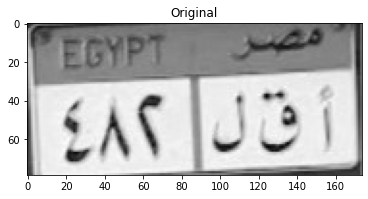

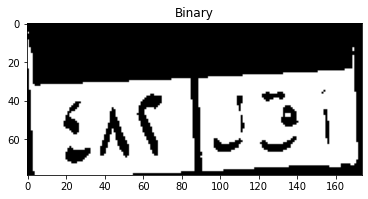

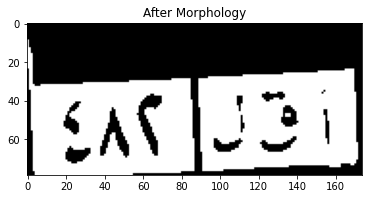

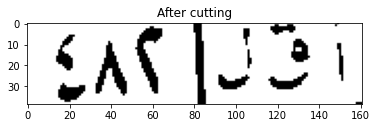

['6', '2', '8', 'ب']


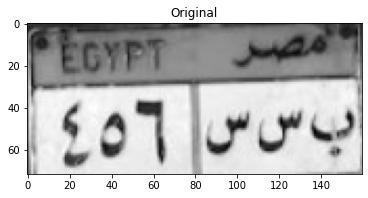

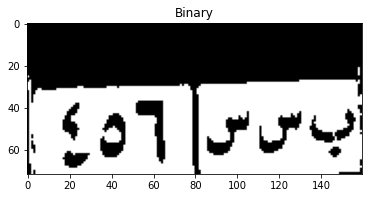

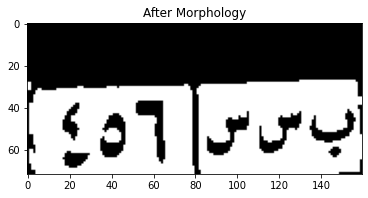

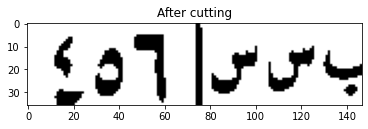

['س', 'س', '6', '5', 'أ']


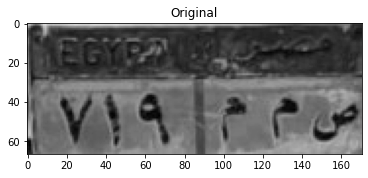

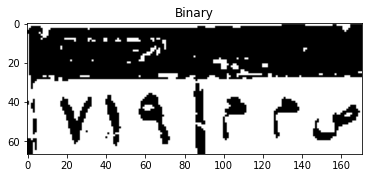

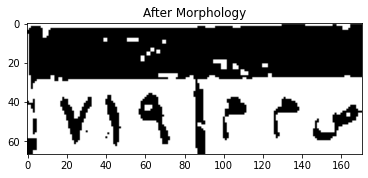

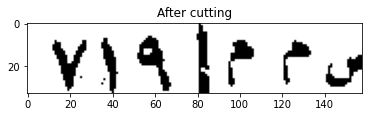

['م', 'م', '9', '1', '7']


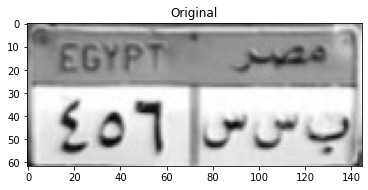

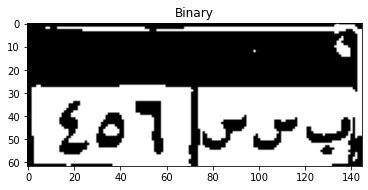

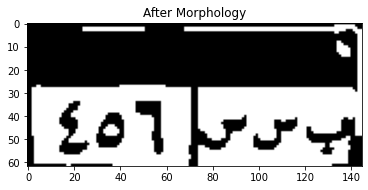

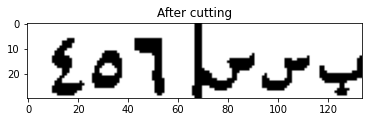

['ب', 'ر', '6', '4']


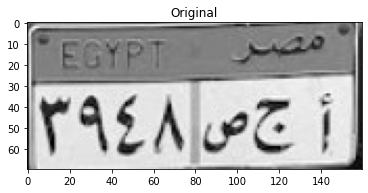

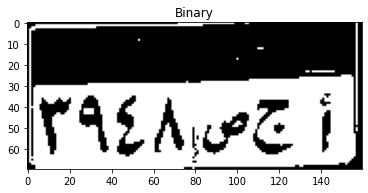

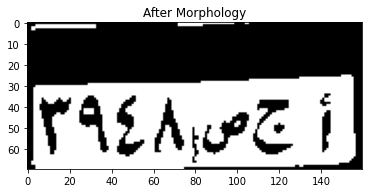

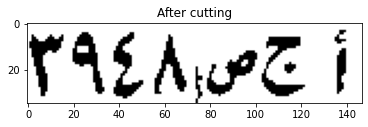

['أ', 'ج', 'ص', '8', '4', '9', '3']


In [196]:
n = 1
for i in os.listdir('plates_dataset/'):
    image = (rgb2gray(io.imread("plates_dataset/" + i)) * 255).astype("uint8")
    show_images([image], ["Original"])
    image = cv.threshold(image, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    show_images([image], ["Binary"])
    x,y = image.shape
    structuringEl = np.ones((2, 2))        
    image = binary_opening(image, structuringEl)
    show_images([image], ["After Morphology"])
    image = image[int(x//2.2):x-int(x//15),int(y//30):y-int(y//20)]
    show_images([image], ["After cutting"])
    charText = getChars(image)
    print(charText)
    n += 1
    if n == 20:
        break
